In [1]:
import constants
import torch
import importlib

from dataloaders.NYU_loader import get_dataloaders

device = constants.DEVICE

In [2]:
test_dl, train_dl = get_dataloaders(batch_size=16)

In [3]:
import torch.nn as nn
import utils.utils as utils


class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, ignore_index=255, reduction='mean'):
        super(CrossEntropyLoss2d, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target)
        return loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1., ignore_index=255):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, output, target):
        if self.ignore_index not in range(target.min(), target.max()):
            if (target == self.ignore_index).sum() > 0:
                target[target == self.ignore_index] = target.min()
        #target = make_one_hot(target.unsqueeze(dim=1), classes=output.size()[1])
        
        target = utils.convert_to_one_hot(target, 13)
        output = torch.nn.functional.softmax(output, dim=1)
        output_flat = output.contiguous().view(-1)
        target_flat = target.contiguous().view(-1)
        intersection = (output_flat * target_flat).sum()
        loss = 1 - ((2. * intersection + self.smooth) /
                    (output_flat.sum() + target_flat.sum() + self.smooth))
        return loss


In [4]:
class CE_DiceLoss(nn.Module):
    def __init__(self, smooth=1, reduction='mean', ignore_index=255, weight=None):
        super(CE_DiceLoss, self).__init__()
        self.smooth = smooth
        self.dice = DiceLoss()
        self.cross_entropy = nn.CrossEntropyLoss(weight=weight, reduction=reduction, ignore_index=ignore_index)
    
    def forward(self, output, target):
        CE_loss = self.cross_entropy(output, target)
        dice_loss = self.dice(output, target)
        return CE_loss + dice_loss

In [5]:
# load the model
import models.ENet
model_state_dict = torch.load("saved_models/ENet_64.pth")
model = models.ENet.ENet(13, 3).to(device=device)
model.load_state_dict()

TypeError: load_state_dict() missing 1 required positional argument: 'state_dict'

: 

In [5]:
import utils.trainers.unet_train
importlib.reload(utils.trainers.unet_train)

import models.ENet
importlib.reload(models.ENet)

from torch import nn as nn

model = models.ENet.ENet(13, 3).to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)

loss_func = torch.nn.CrossEntropyLoss().to(device=device) 

train_Unet = utils.trainers.unet_train.train_Unet

loss1 = train_Unet(model, train_dl, optimizer=optimizer, loss_func=loss_func, num_epochs=15, show_result_every=1)

100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


Epoch 0 loss: 2.3614814281463623


100%|██████████| 41/41 [00:39<00:00,  1.03it/s]


Epoch 1 loss: 2.256417751312256


100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


Epoch 2 loss: 2.2176804542541504


100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


Epoch 3 loss: 2.169273614883423


 41%|████▏     | 17/41 [00:16<00:23,  1.00it/s]


KeyboardInterrupt: 

: 

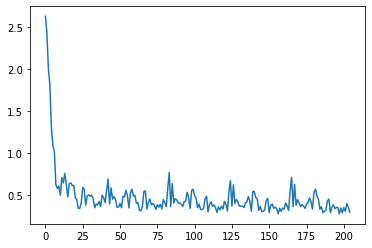

In [8]:
from matplotlib import pyplot as plt

plt.plot(loss1)

tensor([0, 1], device='cuda:0')


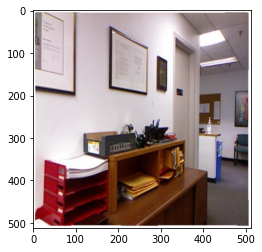

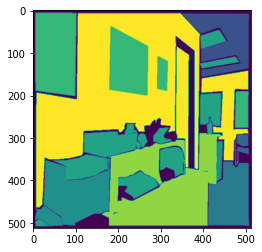

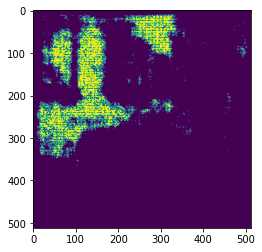

In [9]:
data = next(iter(train_dl))

N = 2

x = data[0].to(device=device).float()
y = data[1].to(device=device).float()[N]

pred = model(x) 

import matplotlib.pyplot as plt
import utils.utils as utils

plt.figure() 
plt.imshow(x[N].cpu().permute(1, 2, 0))
plt.figure()
plt.imshow(y.cpu().squeeze(0))
plt.figure()

pred_mask = utils.convert_to_segmentation(pred) 

plt.imshow(pred_mask[N].cpu())

print(torch.unique(pred_mask)) 